In [ ]:
import re
import pandas as pd
import spacy
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
matplotlib.style.use("seaborn")

<ipython-input-3-2122b7a2d12f>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn")


In [ ]:
train = pd.read_csv("train.csv",encoding = 'utf-8')
test = pd.read_csv("test.csv", encoding = 'utf-8')

In [ ]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
labels = {0: "non-hate", 1: "hate"}
print(labels)

{0: 'non-hate', 1: 'hate'}


In [ ]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


None

In [ ]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


None

Hence there are no null values.

# EDA

Distribution of labels

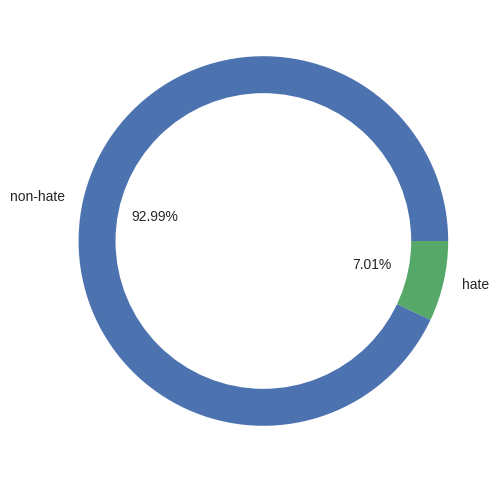

In [ ]:
plt.figure(figsize=(6, 6))

plt.pie(
    train["label"].value_counts(),
    autopct = "%.2f%%",
    labels = ["non-hate", "hate"]
)


circle = plt.Circle((0,0), 0.80,fc='white')

fig = plt.gcf()
fig.gca().add_artist(circle)

plt.show()

Hence the data is clearly unbalanced. Hence we would need better measures than just accuracy in the future -- probably F1 or confusion matrix or ROC-AUC score.

Length of tweets

[Text(0.5, 0, 'Number of Tokens'), Text(0, 0.5, 'Number of Observations')]

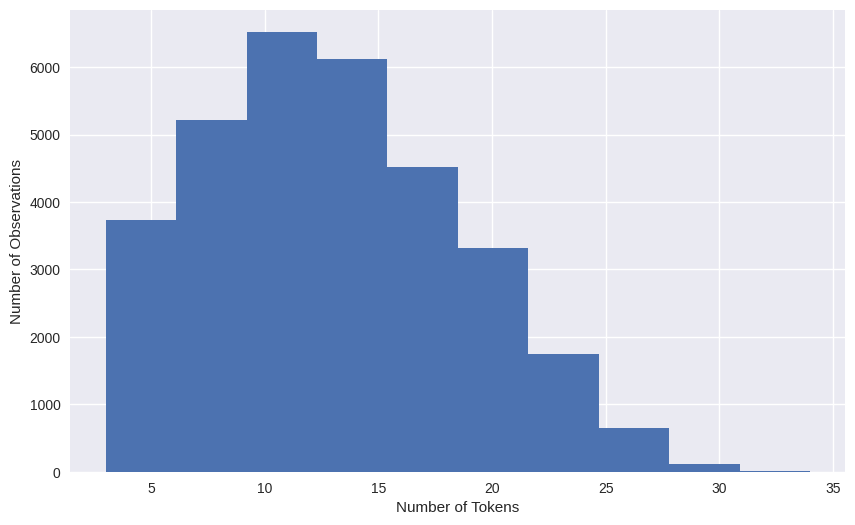

In [ ]:
ax1 = train.tweet.str.split().map(lambda x: len(x)).hist(figsize=(10, 6))
ax1.set(xlabel="Number of Tokens", ylabel="Number of Observations")

Most of the tweets have 5-20 tokens.

BOX plot

Text(0, 0.5, 'Number of Tokens')

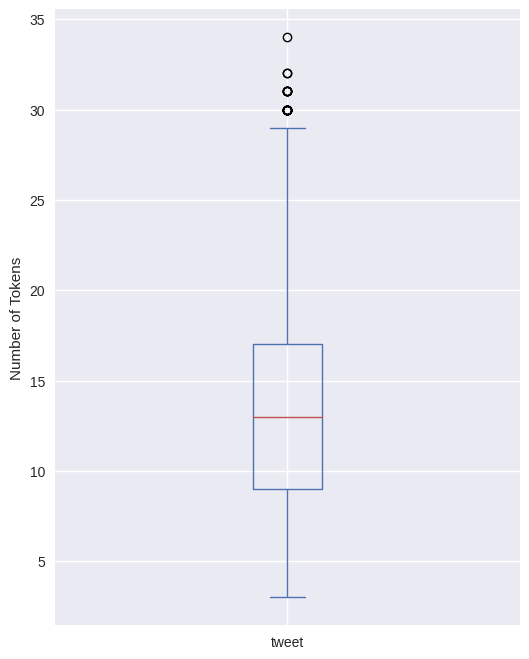

In [ ]:
ax2 = train.tweet.str.split().map(lambda x: len(x)).plot.box(figsize=(6,8))
ax2.set_ylabel("Number of Tokens")

The number of tokens between 25th and 75th %ile (Interquartile range) of data ranges from 9 to 17 tokens, median being around 13 tokens.

Max length of any tweet in the dataset is less than 35 tokens.

# Making Word cloud

In [ ]:
train.shape


(31962, 3)

1. Checking and dropping duplicates

In [ ]:
train = train.drop('id',axis = 'columns')

In [ ]:
train = train.drop_duplicates(keep = 'first')

In [ ]:
train.shape


(29530, 2)

some duplicate values were dropped

2. Removing user tags
3. Removing non-alphanumeric characters

In [ ]:
def preprocess_tweets(df_series):

    df_series = df_series.str.replace("@user", "", regex=False)

    df_series = df_series.str.replace("[^a-zA-Z0-9 ]", " ")
    return df_series

4. Tokenization for creating corpus.
5. removing stopwords

In [ ]:
def tokenize(sentence, remove_stopwords=False):

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = sentence.split()
        tokens = [token for token in tokens if not token.lower() in stop_words]
        return tokens

    return sentence.split()

6. Lemmatization and creating word corpus

In [ ]:
def create_corpus(df_series, remove_stopwords=False):

    corpus = []
    lm = WordNetLemmatizer()
    df_series = preprocess_tweets(df_series)

    for tweet in df_series:
        corpus.extend([lm.lemmatize(word) for word in tokenize(tweet, remove_stopwords=remove_stopwords)])

    return corpus

In [ ]:
offensive_corpus = create_corpus(train[train["label"]==1].tweet, remove_stopwords=True)
non_offensive_corpus = create_corpus(train[train["label"]==0].tweet, remove_stopwords=True)

removing non-ascii characters

In [ ]:
def remove_non_ascii(text):
    return text.encode('ascii', 'ignore').decode('ascii')

In [ ]:
offensive_corpus_removed = [remove_non_ascii(word) for word in offensive_corpus]
non_offensive_corpus_removed = [remove_non_ascii(word) for word in non_offensive_corpus]

Creating word cloud from corpus

In [ ]:
def plot_word_cloud(corpus):

    word_cloud = WordCloud(
        max_words = 100,
        max_font_size = 50,
        collocations = False
    ).generate(str(corpus))

    fig = plt.figure(figsize=(13, 13))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.plot()

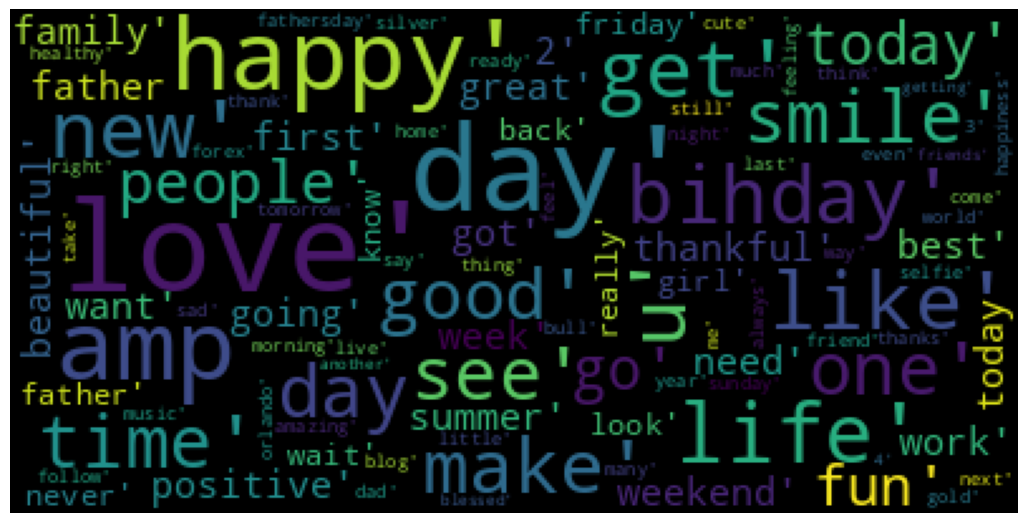

In [ ]:
plot_word_cloud(non_offensive_corpus_removed)

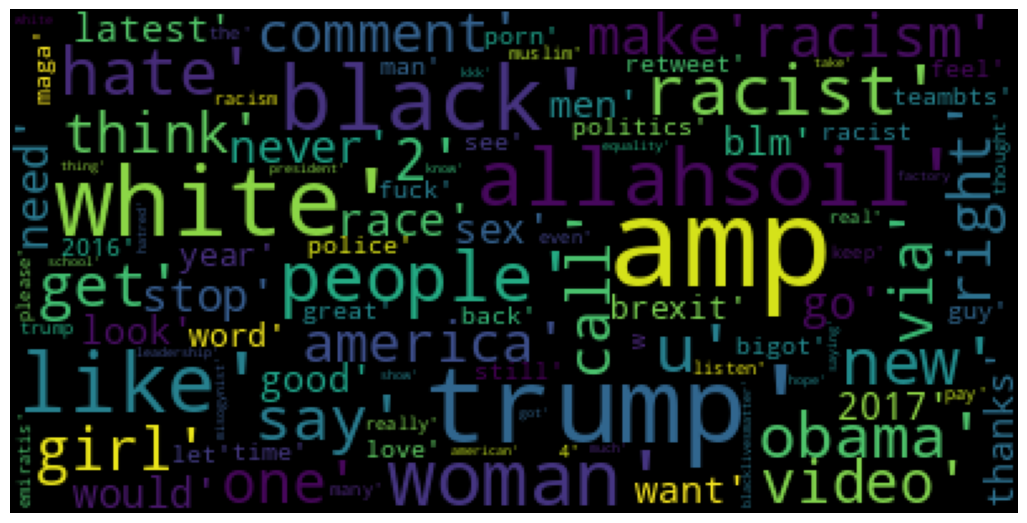

In [ ]:
plot_word_cloud(offensive_corpus_removed)

# Exploring hashtags

We can also explore the hashtags used in the tweets because even they can be used to classify tweets into hate and non-hate

In [ ]:
def get_hash_tags(df_series):

    hash_tags = []
    for text in df_series:
        hash_tags.extend(re.findall(r'#(\w+)', text))

    return hash_tags

In [ ]:
nonhate_hashtags = get_hash_tags(train[train["label"]==0]["tweet"])
hate_hashtags = get_hash_tags(train[train["label"]==1]["tweet"])

In [ ]:
nonhate_hashtag_counts = Counter(nonhate_hashtags)
hate_hashtag_counts = Counter(hate_hashtags)

creating a dataframe for hashtags


In [ ]:
nonhate_hashtag_counts_df = pd.DataFrame.from_dict(nonhate_hashtag_counts, orient="index").reset_index()
nonhate_hashtag_counts_df.columns = ["hashtag", "count"]
nonhate_hashtag_counts_df.sort_values("count", ascending=False, inplace=True)
display(nonhate_hashtag_counts_df.head())

,hashtag,count
33,love,1399
212,smile,537
41,positive,475
183,fun,427
403,life,399


In [ ]:
hate_hashtag_counts_df = pd.DataFrame.from_dict(hate_hashtag_counts, orient="index").reset_index()
hate_hashtag_counts_df.columns = ["hashtag", "count"]
hate_hashtag_counts_df.sort_values("count", ascending=False, inplace=True)
display(hate_hashtag_counts_df.head())

,hashtag,count
22,trump,120
67,allahsoil,89
33,hate,32
20,brexit,27
74,bigot,27


Plotting hashtags

<ipython-input-31-49a76c398f1d>:3: FutureWarning: using <function <lambda> at 0x7cf3ac9970a0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  ax3.set_yticklabels(nonhate_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten())


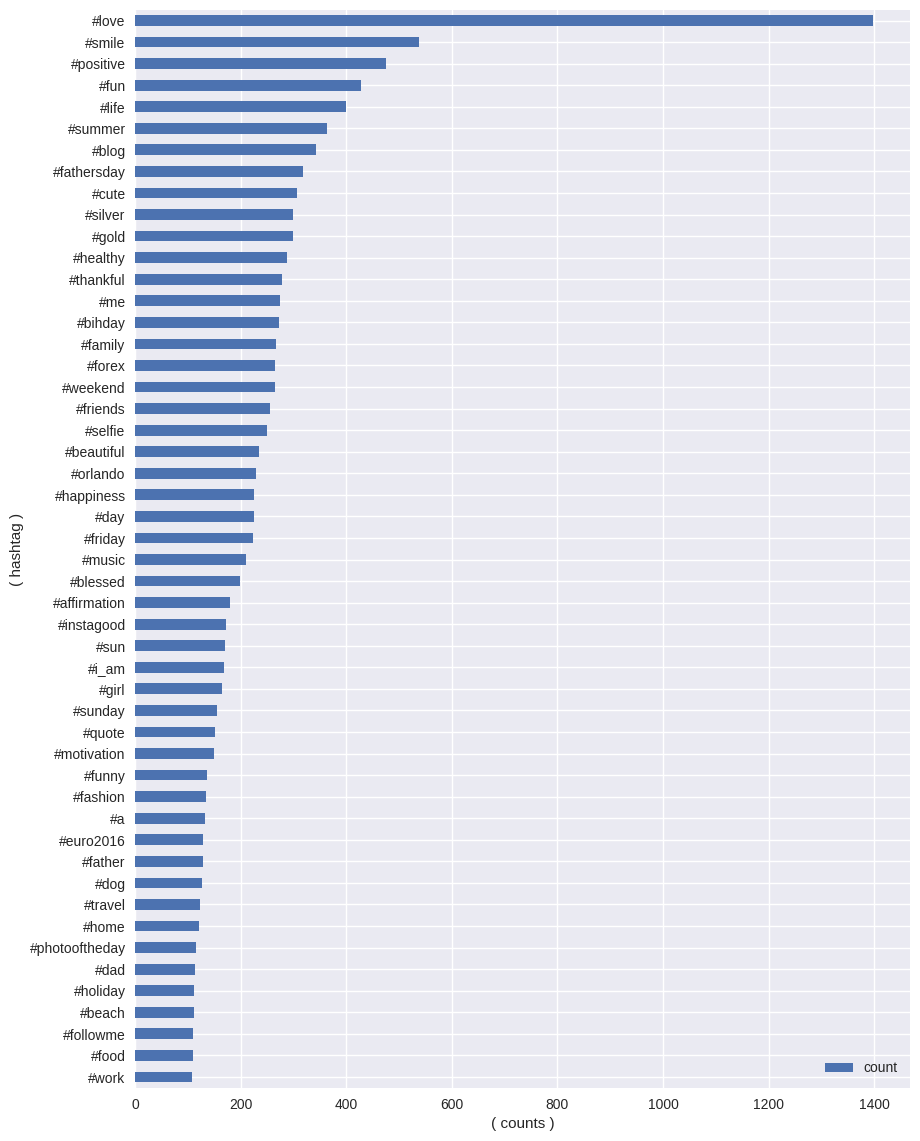

In [ ]:
ax3 = nonhate_hashtag_counts_df.head(50).plot.barh(y="count", figsize=(10, 14))
ax3.set(xlabel="( counts )", ylabel="( hashtag )")
ax3.set_yticklabels(nonhate_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten())
ax3.invert_yaxis()
plt.show()

<ipython-input-32-ddc936a19e0e>:3: FutureWarning: using <function <lambda> at 0x7cf3ad5c4160> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  ax4.set_yticklabels(hate_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten())


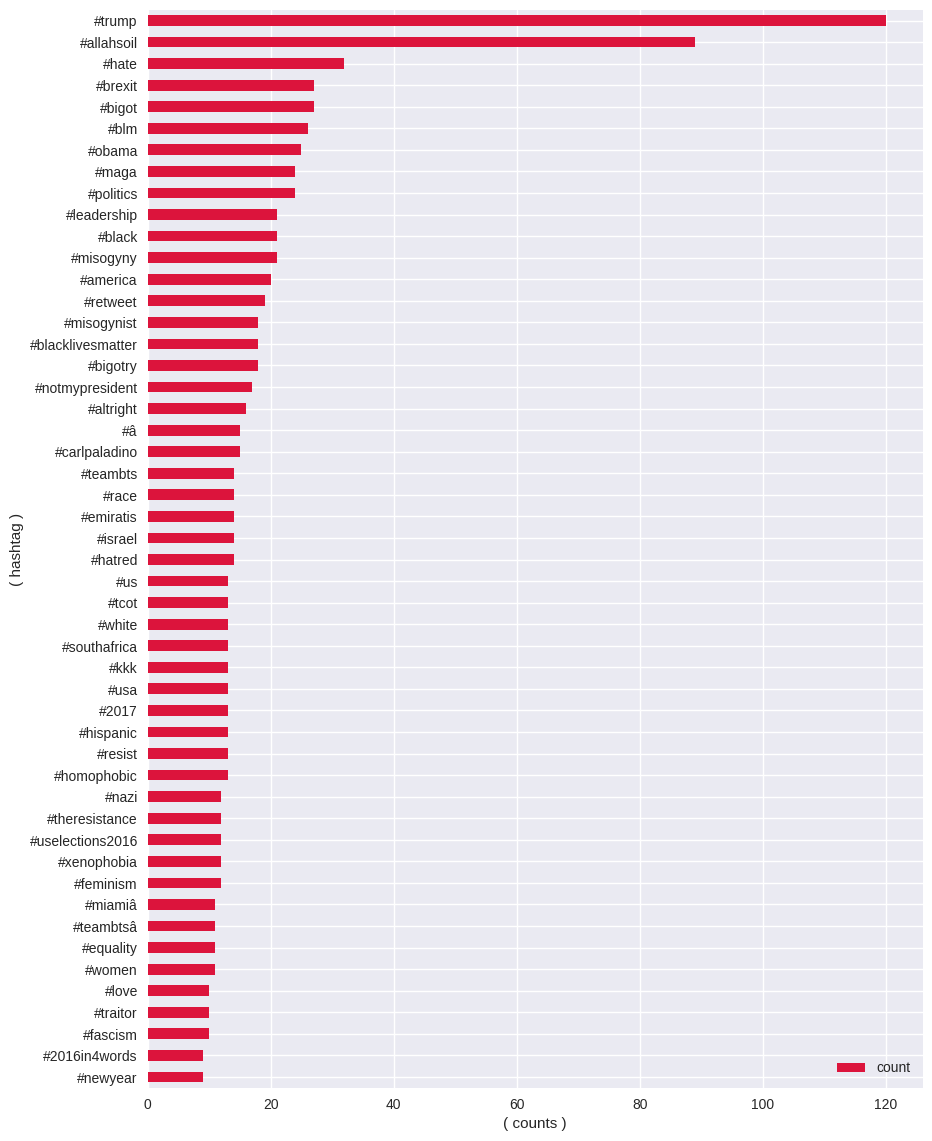

In [ ]:
ax4 = hate_hashtag_counts_df.head(50).plot.barh(y="count", figsize=(10, 14), color="crimson")
ax4.set(xlabel="( counts )", ylabel="( hashtag )")
ax4.set_yticklabels(hate_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten())
ax4.invert_yaxis()
plt.show()

What proportion of tweets contain a hastag??

In [ ]:
def count_rows_with_hashtag(df_series):

    count = 0
    for tweet in df_series:
        if re.search(r'#(\w+)', tweet):
            count+=1

    return count

# Preprocessing

We already showed some of the preprocessing steps we will use above while creating the word corpus for non-hate and hate speech. Here we formalize it step by step and apply it to original train split.

In [ ]:
Word = WordNetLemmatizer()

1. Removing hyperlinks and markups

In [ ]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result)
    return result

2. Removing emojis

In [ ]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

3. Removing punctuation and symbols

In [ ]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

4. Converting to lower case


In [ ]:
def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

5. Removing stopwords

In [ ]:
def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

6. removing '@user'

In [ ]:
def remove_word_user(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

7. Lemmatization

In [ ]:
def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

applying all of them

In [ ]:
def cleaning(df):
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(deEmojify)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
    lemmatize(df)

In [ ]:
import string
stop_words = stopwords.words('english')

In [ ]:
cleaning(train)

In [ ]:
train.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit cant use cause dont offer w...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation


In [ ]:
train['tweet'][20]

'euro people blaming ha conceded goal fat rooney gave away free kick knowing bale hit'

In [ ]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
test.drop('id',axis = 'columns',inplace = True)

In [ ]:
test.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
cleaning(test)

In [ ]:
test.head(n=10)

,tweet
0,studiolife aislife requires passion dedication...
1,white supremacist want everyone see new bird m...
2,safe way heal acne altwaystoheal healthy healing
3,hp cursed child book reservation already yes h...
4,rd bihday amazing hilarious nephew eli ahmir u...
5,choose momtips
6,something inside dy eye ness smokeyeyes tired ...
7,finishedtattooinkedinkloveit thanksaleeee
8,never understand dad left young deep inthefeels
9,delicious food lovelife capetown mannaepicure ...


However we later realised that we dont have the actual labels for test set hence we will be splitting the train set only.

# Creating Baselines

for baselines we will not perform any feature extraction we will just use Word vectorization.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix


Splitting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['tweet'], train['label'], test_size=0.2, random_state=42, stratify=train['label'])

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23624,), (5906,), (23624,), (5906,))

We will use both Count Vectorizer and tf-idf vectorizer.

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [ ]:
results = {}

In [ ]:
def evaluate_model(vectorizer, model_name, model):
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store results
    results[(vectorizer.__class__.__name__, model_name)] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'AUC-ROC': auc_roc,
        'Confusion Matrix': conf_matrix
    }

In [ ]:
evaluate_model(count_vectorizer, 'Logistic Regression', LogisticRegression(max_iter=1000))
evaluate_model(tfidf_vectorizer, 'Logistic Regression', LogisticRegression(max_iter=1000))


In [ ]:
evaluate_model(count_vectorizer, 'Naive Bayes', MultinomialNB())
evaluate_model(tfidf_vectorizer, 'Naive Bayes', MultinomialNB())


In [ ]:
evaluate_model(count_vectorizer, 'Perceptron', Perceptron())
evaluate_model(tfidf_vectorizer, 'Perceptron', Perceptron())

In [ ]:
evaluate_model(count_vectorizer, 'Decision Tree', DecisionTreeClassifier())
evaluate_model(tfidf_vectorizer, 'Decision Tree', DecisionTreeClassifier())

In [ ]:
evaluate_model(count_vectorizer, 'Random Forest', RandomForestClassifier())
evaluate_model(tfidf_vectorizer, 'Random Forest', RandomForestClassifier())

In [ ]:
evaluate_model(count_vectorizer, 'SVM', SVC(probability=True))
evaluate_model(tfidf_vectorizer, 'SVM', SVC(probability=True))

In [ ]:
results_df = pd.DataFrame(results).T

In [ ]:
results_df.drop(columns=['Confusion Matrix'], inplace=True)

Confusion matrix for all tried baselines


In [ ]:
for key, value in results.items():
    print(f"\nConfusion Matrix for {key}:")
    print(value['Confusion Matrix'])


Confusion Matrix for ('CountVectorizer', 'Logistic Regression'):
[[5471   32]
 [ 212  191]]

Confusion Matrix for ('TfidfVectorizer', 'Logistic Regression'):
[[5495    8]
 [ 301  102]]

Confusion Matrix for ('CountVectorizer', 'Naive Bayes'):
[[5476   27]
 [ 213  190]]

Confusion Matrix for ('TfidfVectorizer', 'Naive Bayes'):
[[5503    0]
 [ 376   27]]

Confusion Matrix for ('CountVectorizer', 'Perceptron'):
[[5381  122]
 [ 148  255]]

Confusion Matrix for ('TfidfVectorizer', 'Perceptron'):
[[5394  109]
 [ 160  243]]

Confusion Matrix for ('CountVectorizer', 'Decision Tree'):
[[5356  147]
 [ 173  230]]

Confusion Matrix for ('TfidfVectorizer', 'Decision Tree'):
[[5348  155]
 [ 156  247]]

Confusion Matrix for ('CountVectorizer', 'Random Forest'):
[[5472   31]
 [ 202  201]]

Confusion Matrix for ('TfidfVectorizer', 'Random Forest'):
[[5480   23]
 [ 195  208]]

Confusion Matrix for ('CountVectorizer', 'SVM'):
[[5491   12]
 [ 246  157]]

Confusion Matrix for ('TfidfVectorizer', 'SVM'):
[

In [ ]:
count_vectorizer_df = results_df.loc[results_df.index.get_level_values(0) == 'CountVectorizer']

tfidf_vectorizer_df = results_df.loc[results_df.index.get_level_values(0) == 'TfidfVectorizer']

In [ ]:
count_vectorizer_df.sort_values(by='F1 Score', ascending=False)

Accuracy  F1 Score   AUC-ROC
CountVectorizer Random Forest        0.960549  0.955538  0.935104
                Naive Bayes          0.959363  0.953606  0.937036
                Perceptron           0.954284  0.953576       N/A
                Logistic Regression  0.958686  0.953079  0.953353
                SVM                  0.956316  0.947835  0.943527
                Decision Tree        0.945818  0.944979   0.78072

In [ ]:
tfidf_vectorizer_df.sort_values(by='F1 Score', ascending=False)

Accuracy  F1 Score   AUC-ROC
TfidfVectorizer Random Forest        0.963088  0.958365  0.942922
                Perceptron           0.954453   0.95302       N/A
                SVM                  0.956485  0.947881  0.953353
                Decision Tree        0.947342  0.947311  0.799954
                Logistic Regression   0.94768  0.933417  0.950782
                Naive Bayes          0.936336  0.909553  0.922716

In [ ]:
count_vectorizer_df_reset = count_vectorizer_df.reset_index()
tfidf_vectorizer_df_reset = tfidf_vectorizer_df.reset_index()


In [ ]:
print(count_vectorizer_df_reset.columns)

Index(['level_0', 'level_1', 'Accuracy', 'F1 Score', 'AUC-ROC'], dtype='object')


In [ ]:
def plot_sorted_performance_gradient(results_df, metric, title):

    sorted_df = results_df.sort_values(by=metric, ascending=False)

    plt.figure(figsize=(10, 6))

    palette = sns.light_palette("blue", len(sorted_df), reverse=True)

    sns.barplot(x='level_1', y=metric, data=sorted_df, palette=palette)

    for i, value in enumerate(sorted_df[metric]):
        plt.text(i, value + 0.001, f'{value:.4f}', ha='center', va='bottom', color='black', fontsize=10)


    plt.xticks(rotation=90)
    plt.title(f'{title} Sorted by {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.show()

In [ ]:
count_vectorizer_df_reset = count_vectorizer_df.reset_index()
tfidf_vectorizer_df_reset = tfidf_vectorizer_df.reset_index()

<ipython-input-73-869ae9735e11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='level_1', y=metric, data=sorted_df, palette=palette)


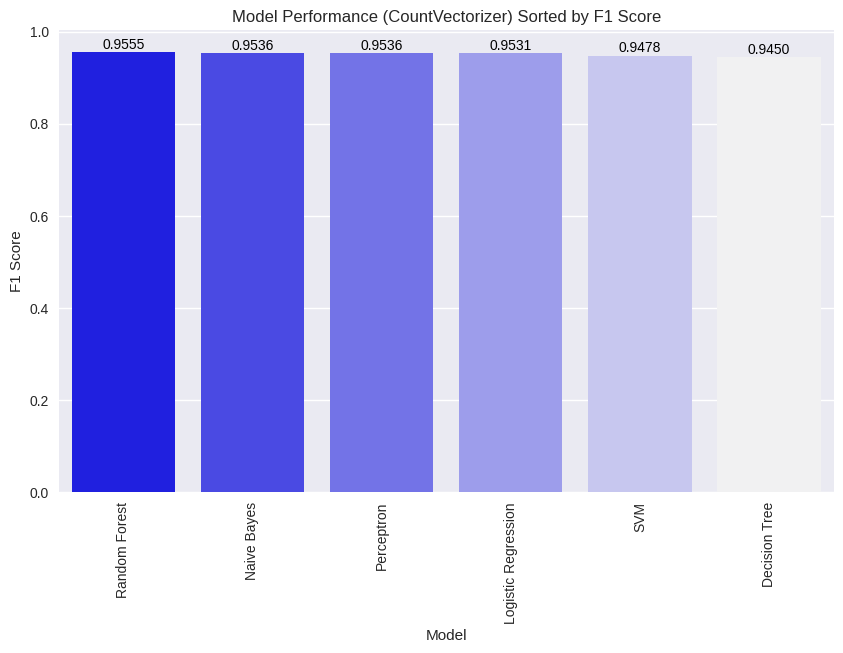

<ipython-input-73-869ae9735e11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='level_1', y=metric, data=sorted_df, palette=palette)


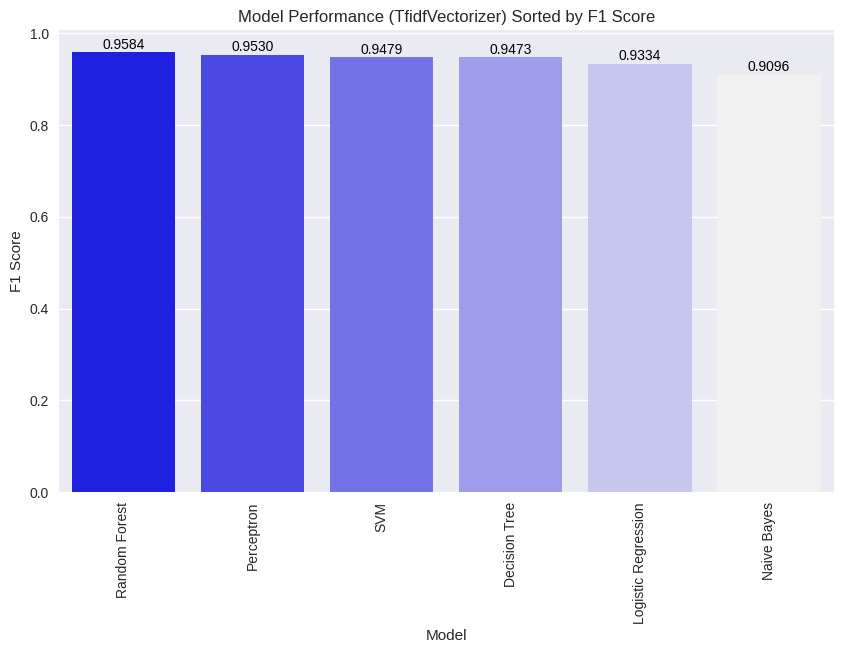

In [ ]:
plot_sorted_performance_gradient(count_vectorizer_df_reset, 'F1 Score', 'Model Performance (CountVectorizer)')
plot_sorted_performance_gradient(tfidf_vectorizer_df_reset, 'F1 Score', 'Model Performance (TfidfVectorizer)')

<ipython-input-73-869ae9735e11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='level_1', y=metric, data=sorted_df, palette=palette)


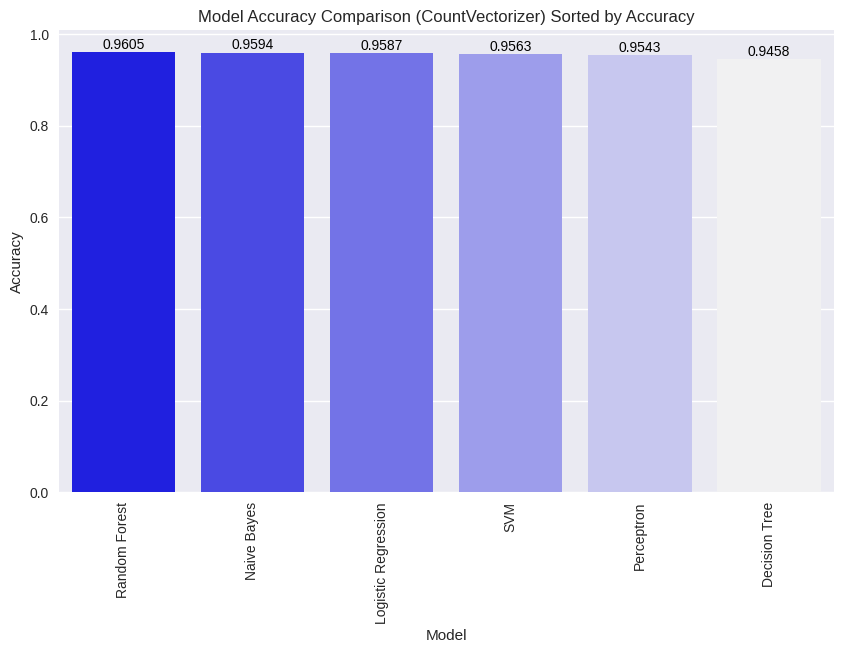

<ipython-input-73-869ae9735e11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='level_1', y=metric, data=sorted_df, palette=palette)


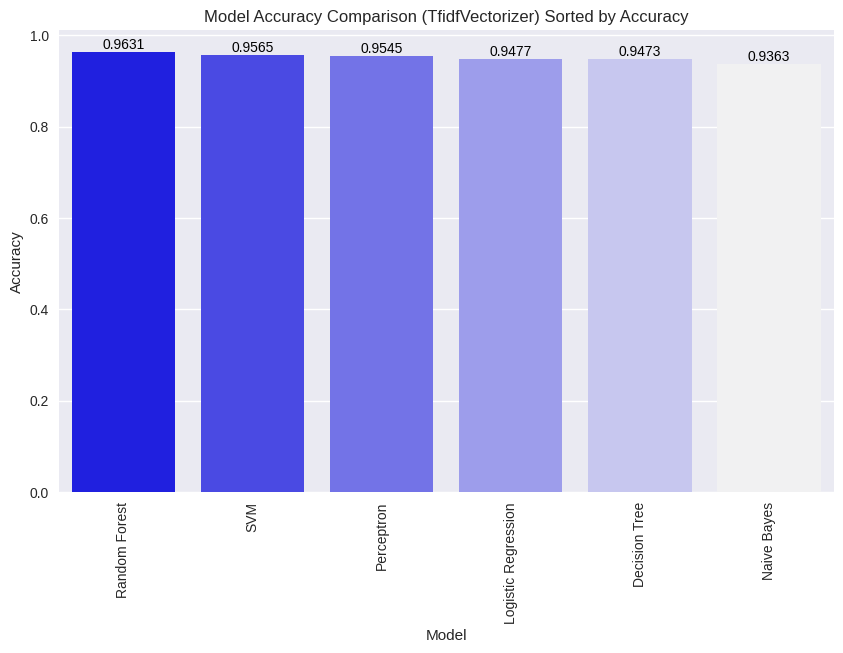

In [ ]:
plot_sorted_performance_gradient(count_vectorizer_df_reset, 'Accuracy', 'Model Accuracy Comparison (CountVectorizer)')
plot_sorted_performance_gradient(tfidf_vectorizer_df_reset, 'Accuracy', 'Model Accuracy Comparison (TfidfVectorizer)')

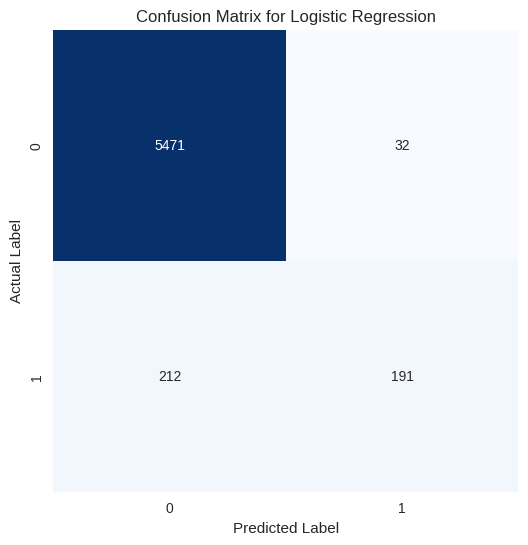

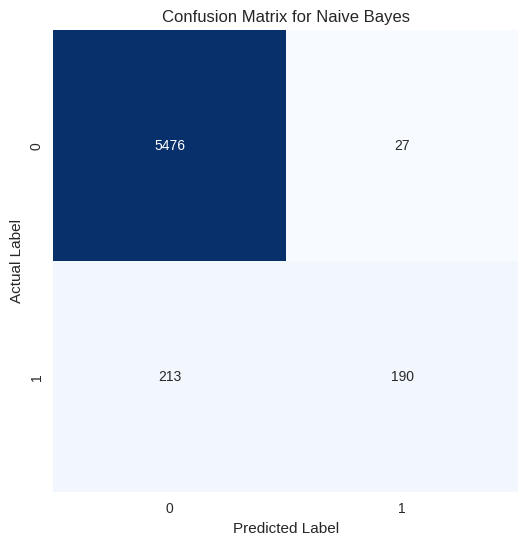

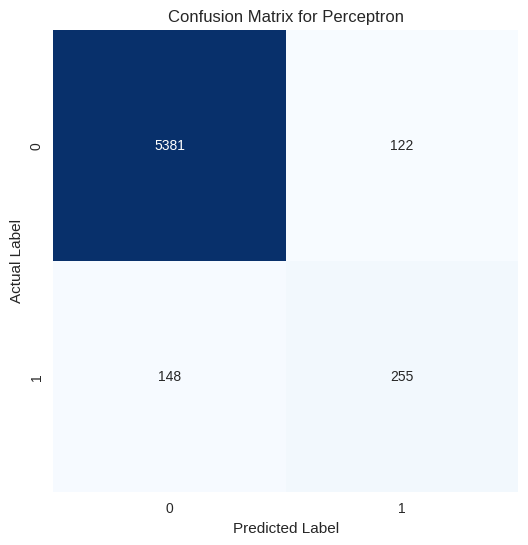

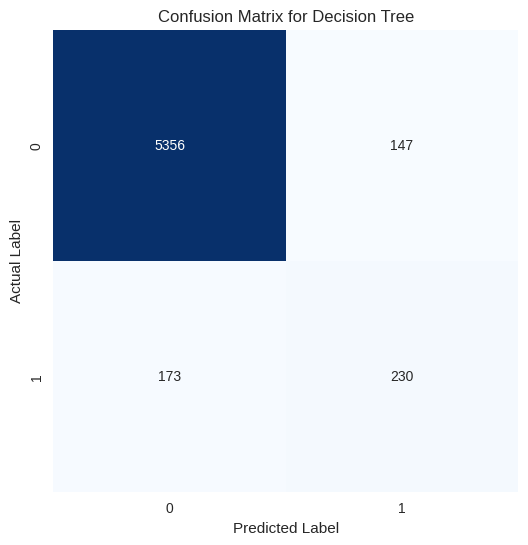

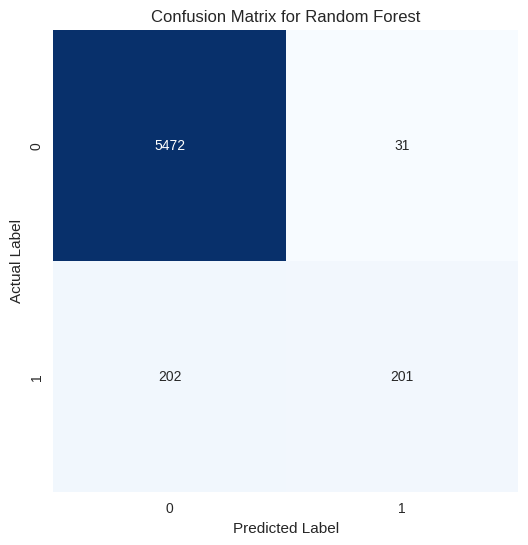

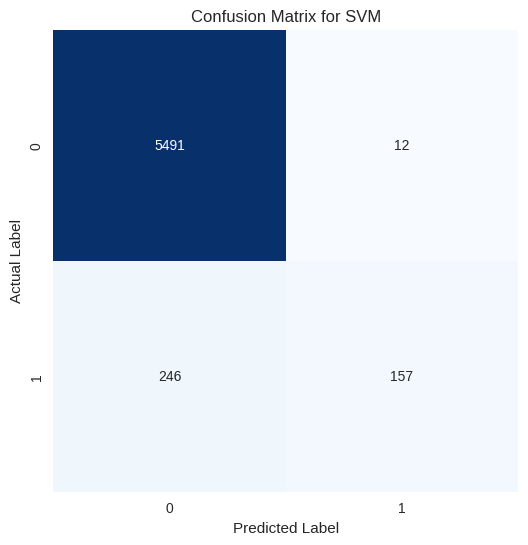

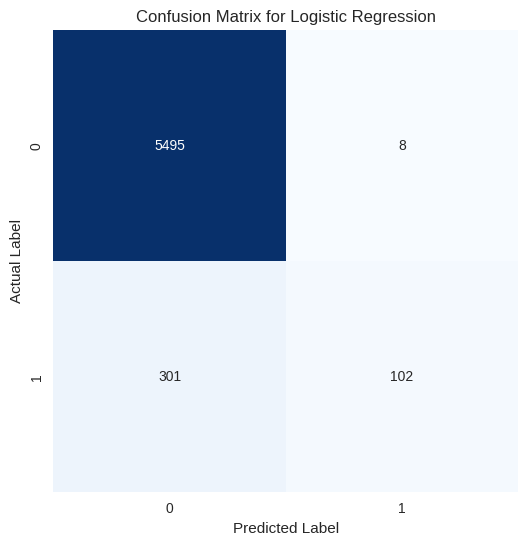

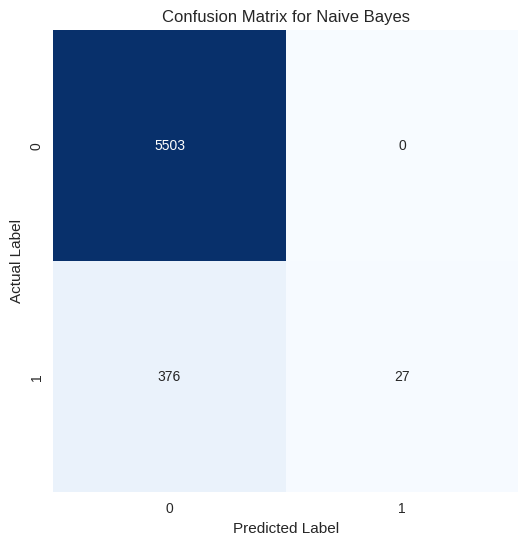

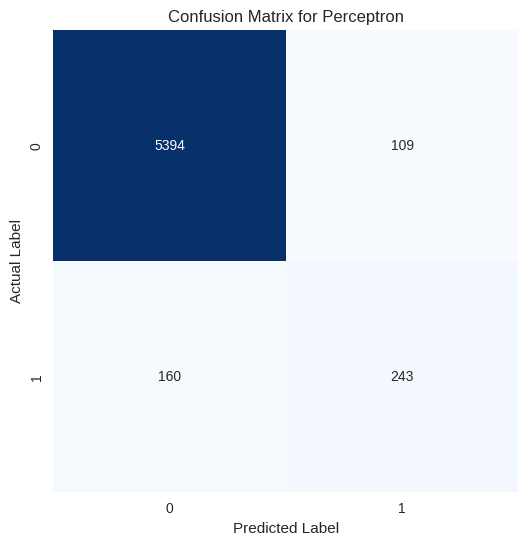

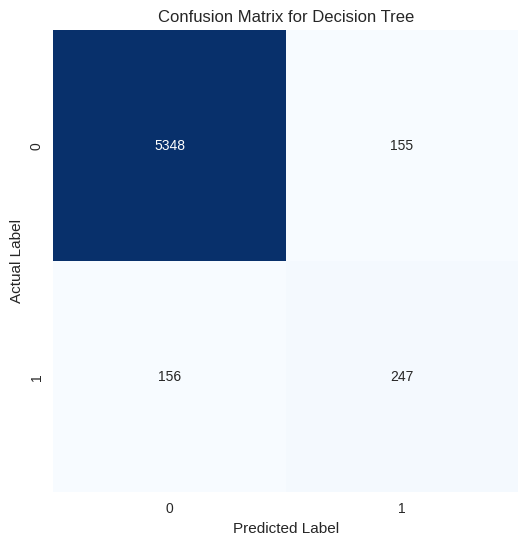

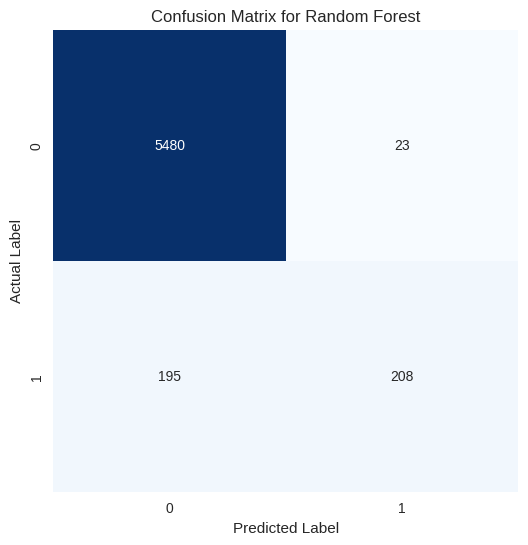

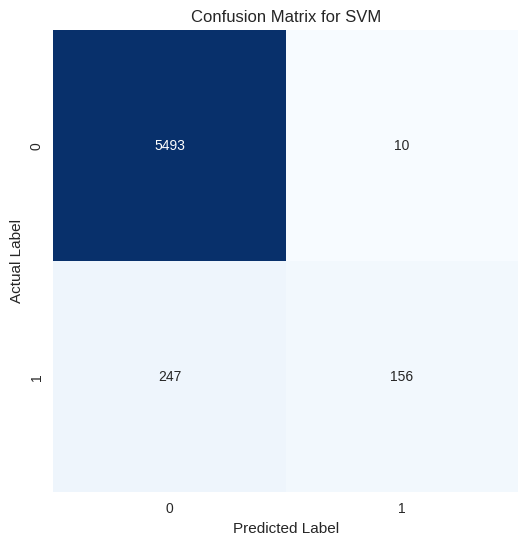

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_all_confusion_matrices(results, vectorizer_type):
    for model_name, model_data in results.items():
        if model_name[0] == vectorizer_type:
            conf_matrix = model_data['Confusion Matrix']
            plot_confusion_matrix(conf_matrix, model_name[1])

plot_all_confusion_matrices(results, 'CountVectorizer')

plot_all_confusion_matrices(results, 'TfidfVectorizer')
